In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config inlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('Data.csv')
funding = pd.read_csv("NCAP_Funding.csv")
statedata = pd.read_csv("State_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Data.csv'

#### After making sure that all entries which have state as NaN, drop those entries into a seperate dataframe to report to the authorities for not even providing any kind of data

In [ ]:
cities_with_nan_state = df[df['state'].isna()]
df = df.dropna(subset=['state'])
df.reset_index(drop=True, inplace=True)


#### Now to remove the entries which have both PM2.5 and PM10 as NaN and report to the state authorities for not measuring/providing the data asked

In [ ]:
pm_nan_df = df[df['PM2.5'].isna() & df['PM10'].isna()]
df = df.dropna(subset=['PM2.5', 'PM10'], how='all')
df.reset_index(drop=True, inplace=True)

### Spatial Aggregation

In [ ]:
df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce')
state_avg_pm25 = df.groupby('state')['PM2.5'].mean()
highest_pm25_state = state_avg_pm25.idxmax()
highest_pm25_value = state_avg_pm25.max()
print(f"State with highest average PM2.5: {highest_pm25_state} ({highest_pm25_value:.2f})")

State with highest average PM2.5: Delhi (104.10)


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_2023 = df[df['Timestamp'].dt.year == 2023]
hazardous_days = df_2023[df_2023['PM2.5'] > 300]
hazardous_days_count = hazardous_days.groupby('state').size()
most_hazardous_state = hazardous_days_count.idxmax()
most_hazardous_days = hazardous_days_count.max()
print(f"State with the most hazardous PM2.5 days in 2023: {most_hazardous_state} ({most_hazardous_days} days)")

State with the most hazardous PM2.5 days in 2023: Delhi (470 days)


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_2023 = df[df['Timestamp'].dt.year == 2023]
df_2023['PM2.5'] = pd.to_numeric(df_2023['PM2.5'], errors='coerce')
#can proceed without dropping NaN values as the NaN values will not be considered in the calculation
state_pm25_variability = df_2023.groupby('state')['PM2.5'].std()
most_variable_state = state_pm25_variability.idxmax()
highest_variability = state_pm25_variability.max()
print(f"State with the highest PM2.5 variability in 2023: {most_variable_state} (Std Dev: {highest_variability:.2f})")

State with the highest PM2.5 variability in 2023: Delhi (Std Dev: 82.80)


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_covid_period = df[(df['Timestamp'].dt.year >= 2020) & (df['Timestamp'].dt.year <= 2021)]
df_covid_period['PM2.5'] = pd.to_numeric(df_covid_period['PM2.5'], errors='coerce')
state_avg_pm25 = df_covid_period.groupby('state')['PM2.5'].mean()
lowest_pm25_state = state_avg_pm25.idxmin()
lowest_pm25_value = state_avg_pm25.min()
print(f"State with the lowest average PM2.5 levels during the Covid period (2020-2021): {lowest_pm25_state} ({lowest_pm25_value:.2f})")

State with the lowest average PM2.5 levels during the Covid period (2020-2021): Mizoram (14.32)


### Temporal aggregation

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_aug2020 = df[(df['Timestamp'].dt.year == 2020) & (df['Timestamp'].dt.month == 8)]
df_aug2020['PM2.5'] = pd.to_numeric(df_aug2020['PM2.5'], errors='coerce')
max_row = df_aug2020.loc[df_aug2020['PM2.5'].idxmax()]
station = max_row['station']
max_pm25 = max_row['PM2.5']
print(f"Station that recorded the highest PM2.5 in Aug 2020: {station} (PM2.5: {max_pm25:.2f})")

Station that recorded the highest PM2.5 in Aug 2020: Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB (PM2.5: 805.51)


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
target_station = "Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB"
filtered = df[(df['year'] == 2018) & (df['station'] == target_station)]
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return None

filtered['season'] = filtered['month'].apply(get_season)
filtered = filtered.dropna(subset=['season'])
season_avg = filtered.groupby('season')['PM2.5'].mean().reset_index()
highest_season = season_avg.loc[season_avg['PM2.5'].idxmax()]
print("Average PM2.5 per season:")
print(season_avg)
print("\nSeason with the highest PM2.5:", highest_season['season'])

Average PM2.5 per season:
    season      PM2.5
0  Monsoon  34.425196
1   Winter  67.492344

Season with the highest PM2.5: Winter


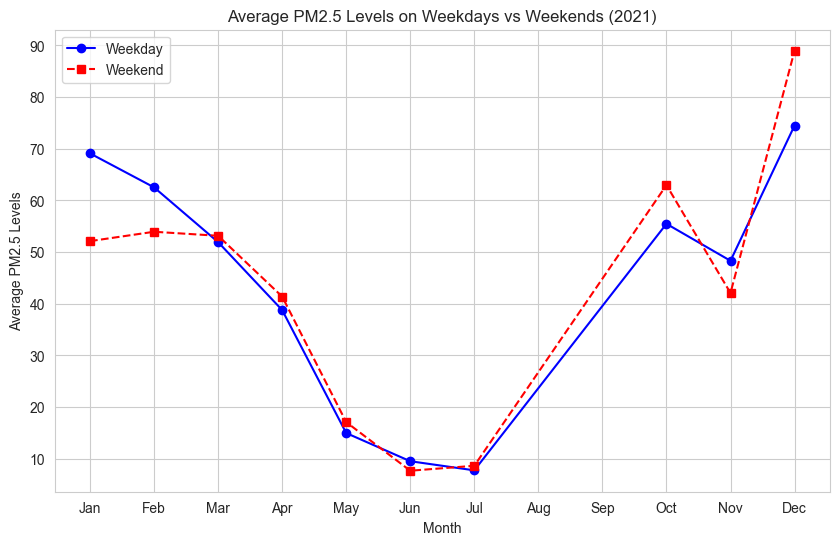

In [ ]:
data_2021 = df[(df["Timestamp"].dt.year == 2021) & (df["station"] == "Lal Bahadur Shastri Nagar, Kalaburagi - KSPCB")]
data_2021 = data_2021.dropna(subset=["PM2.5"])

data_2021["DayType"] = data_2021["Timestamp"].dt.weekday.apply(lambda x: "Weekend" if x >= 5 else "Weekday") # Add 'DayType' column (Weekdays (0-4), Weekends (5-6))

# Group by month and day type, then calculate average PM2.5
avg_pm25 = data_2021.groupby([data_2021["Timestamp"].dt.month, "DayType"])["PM2.5"].mean().reset_index() # .dt.month already creates a proper column for months.

# Rename first column to 'Month'
avg_pm25.rename(columns={avg_pm25.columns[0]: "Month"}, inplace=True) # not required but ok
# Pivot table for easier plotting
pivot_table = avg_pm25.pivot(index="Month", columns="DayType", values="PM2.5").fillna(0)  # Replace NaNs with 0

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(pivot_table.index, pivot_table["Weekday"], label="Weekday", marker="o", linestyle="-", color="blue")
plt.plot(pivot_table.index, pivot_table["Weekend"], label="Weekend", marker="s", linestyle="--", color="red")
plt.xlabel("Month")
plt.ylabel("Average PM2.5 Levels")
plt.title("Average PM2.5 Levels on Weekdays vs Weekends (2021)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True)
plt.show()

### Spatio Temporal Aggregations

In [ ]:
# 1 For each state, calculate the percentage increase or decrease in PM2.5 levels during monsoon months (June to September) compared to summer months (March to May).

# Filter data for the year 2022
data_2022 = df[df['Timestamp'].dt.year == 2022]

def get_season(date):
    if date.month in [3, 4, 5]:
        return 'Summer'
    elif date.month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Other'

# Add a 'Season' column
# data_2022['Season'] = data_2022['Timestamp'].apply(get_season) will get warning lol!

data_2022 = df[df['Timestamp'].dt.year == 2022].copy()  # Make an explicit copy
data_2022['Season'] = data_2022['Timestamp'].apply(get_season)  # No warning now

# Filter data for summer and monsoon seasons
summer_monsoon = data_2022[data_2022['Season'].isin(['Summer', 'Monsoon'])]

# Group by state and season, then calculate average PM2.5
avg_pm25 = summer_monsoon.groupby(['state', 'Season'])['PM2.5'].mean().reset_index()

# Pivot the data
pivot_table = avg_pm25.pivot(index='state', columns='Season', values='PM2.5')
pivot_table = pivot_table.fillna(0)

pivot_table['Percentage Change'] = ((pivot_table['Monsoon'] - pivot_table['Summer']) / pivot_table['Summer']) * 100 # Percentage change

# Find the state with the most difference (increase or decrease)
difference = pivot_table.loc[pivot_table['Percentage Change'].abs().idxmax()]

print("\nState with the most difference (increase or decrease):")
print(difference)
print("Percentage change in PM2.5 levels (Monsoon vs Summer) for each state in 2022:")
print(pivot_table)


State with the most difference (increase or decrease):
Season
Monsoon              21.872292
Summer               56.337647
Percentage Change   -61.176419
Name: Assam, dtype: float64
Percentage change in PM2.5 levels (Monsoon vs Summer) for each state in 2022:
Season               Monsoon     Summer  Percentage Change
state                                                     
Andhra Pradesh     19.355510  30.128540         -35.756894
Arunachal Pradesh  15.069892  32.116292         -53.077110
Assam              21.872292  56.337647         -61.176419
Bihar              35.642356  75.834868         -53.000042
Chandigarh         32.758585  59.695914         -45.124242
Chhattisgarh       19.871696  22.321561         -10.975330
Delhi              42.769572  95.667628         -55.293579
Gujarat            35.852728  65.113078         -44.937747
Haryana            41.922458  81.727661         -48.704688
Himachal Pradesh   38.686133  61.471943         -37.067008
Jammu and Kashmir  18.049643  

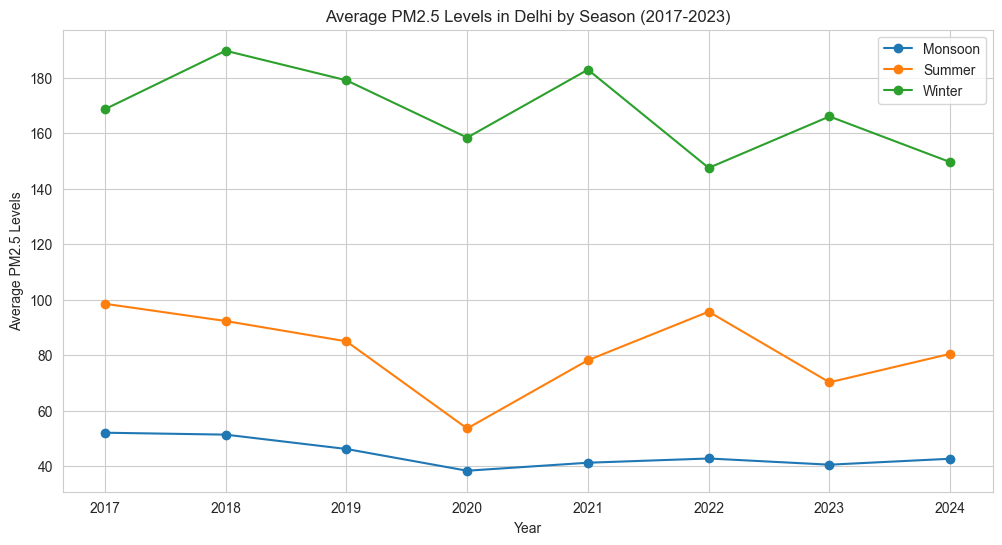

In [ ]:
# 2 Plot the average PM2.5 levels for Delhi across each season (Winter: December-February, Summer: March-May, Monsoon: June-September) from 2017 to 2023. What seasonal variation, if any, can you observe in pollution levels?

# Filter data for Delhi
delhi_data = df[df['city'] == 'Delhi']

def season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Summer'
    elif date.month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

delhi_data = df[df['state'] == "Delhi"].copy()
delhi_data['Season'] = delhi_data['Timestamp'].apply(season)

# Filter data for Winter, Summer, and Monsoon
delhi_seasonal_data = delhi_data[delhi_data['Season'].isin(['Winter', 'Summer', 'Monsoon'])]

# Group by year and season, then calculate average PM2.5
delhi_seasonal_avg = delhi_seasonal_data.groupby([delhi_seasonal_data['Timestamp'].dt.year, 'Season'])['PM2.5'].mean().reset_index()
delhi_seasonal_avg.rename(columns={'Timestamp': 'Year'}, inplace=True)

# Pivot
delhi_pivot = delhi_seasonal_avg.pivot(index='Year', columns='Season', values='PM2.5')

# Plot the data
plt.figure(figsize=(12, 6))
for season in delhi_pivot.columns:
    plt.plot(delhi_pivot.index, delhi_pivot[season], label=season, marker='o')

plt.xlabel('Year')
plt.ylabel('Average PM2.5 Levels')
plt.title('Average PM2.5 Levels in Delhi by Season (2017-2023)')
plt.legend()
plt.grid(True)
plt.show()

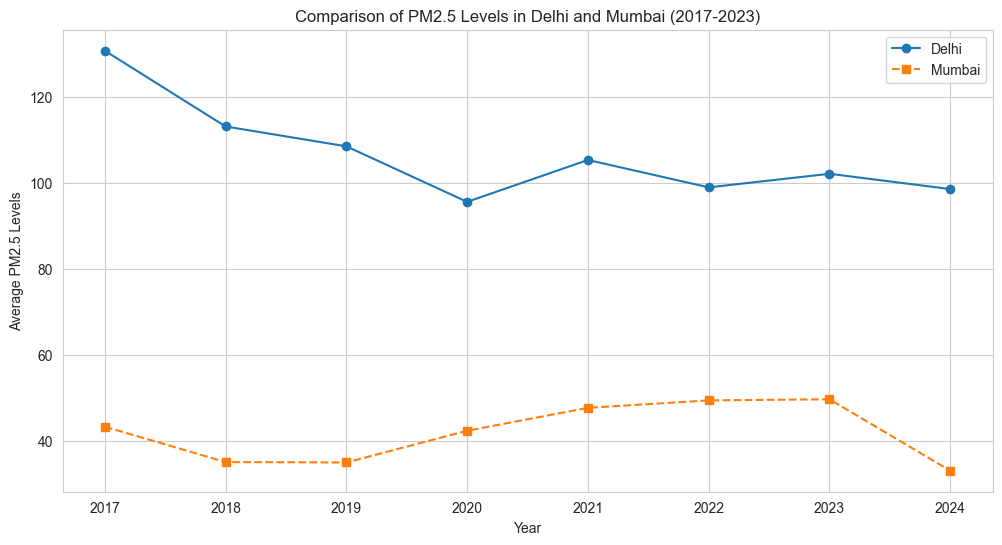


Fluctuations (Standard Deviation) in PM2.5 Levels:
Delhi: 11.33
Mumbai: 6.83
Delhi had more fluctuations in PM2.5 levels.


In [ ]:
# 3 Plot a time-series graph comparing Delhi’s PM2.5 levels with Mumbai’s from 2017 to 2023. Which city had more fluctuations?

# Filter data for Delhi and Mumbai
dm_data = df[df['city'].isin(['Delhi', 'Mumbai'])]

# Group by city and year, then calculate average PM2.5
avg_pm25 = dm_data.groupby(['city', dm_data['Timestamp'].dt.year])['PM2.5'].mean().reset_index()
avg_pm25.columns = ['City', 'Year', 'PM2.5']  # Rename columns properly

city_pivot = avg_pm25.pivot(index='Year', columns='City', values='PM2.5')
plt.figure(figsize=(12, 6))

# Check if Delhi data exists before plotting
if 'Delhi' in city_pivot.columns:
    plt.plot(city_pivot.index, city_pivot['Delhi'], label='Delhi', marker='o', linestyle='-')

# Check if Mumbai data exists before plotting
if 'Mumbai' in city_pivot.columns:
    plt.plot(city_pivot.index, city_pivot['Mumbai'], label='Mumbai', marker='s', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Average PM2.5 Levels')
plt.title('Comparison of PM2.5 Levels in Delhi and Mumbai (2017-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate fluctuations (standard deviation)
delhi_fluctuation = city_pivot['Delhi'].std() if 'Delhi' in city_pivot.columns else None
mumbai_fluctuation = city_pivot['Mumbai'].std() if 'Mumbai' in city_pivot.columns else None

# Print fluctuations
print("\nFluctuations (Standard Deviation) in PM2.5 Levels:")
if delhi_fluctuation is not None:
    print(f"Delhi: {delhi_fluctuation:.2f}")
if mumbai_fluctuation is not None:
    print(f"Mumbai: {mumbai_fluctuation:.2f}")

# Determine which city had more fluctuations
if delhi_fluctuation and mumbai_fluctuation:
    if delhi_fluctuation > mumbai_fluctuation:
        print("Delhi had more fluctuations in PM2.5 levels.")
    else:
        print("Mumbai had more fluctuations in PM2.5 levels.")

### Population based

In [ ]:
station_counts = df[['state', 'station']].drop_duplicates()['state'].value_counts()

# Create a dataframe with population and station counts
density_df = pd.DataFrame({
    'population': statedata.set_index('State')['Population'],
    'stations': station_counts
}).fillna(0)

# Calculate stations per million people
density_df['stations_per_million'] = (density_df['stations'] * 1000000 / density_df['population'])

# Find state with highest density
highest_density_state = density_df['stations_per_million'].idxmax()
stations = density_df.loc[highest_density_state, 'stations']
population = density_df.loc[highest_density_state, 'population']
density = density_df.loc[highest_density_state, 'stations_per_million']

print(f"State with highest monitoring station density: {highest_density_state}")
print(f"Number of stations: {stations:.0f}")
print(f"Population: {population:,.0f}")
print(f"Stations per million people: {density:.2f}")

State with highest monitoring station density: Chandigarh
Number of stations: 3
Population: 1,055,450
Stations per million people: 2.84


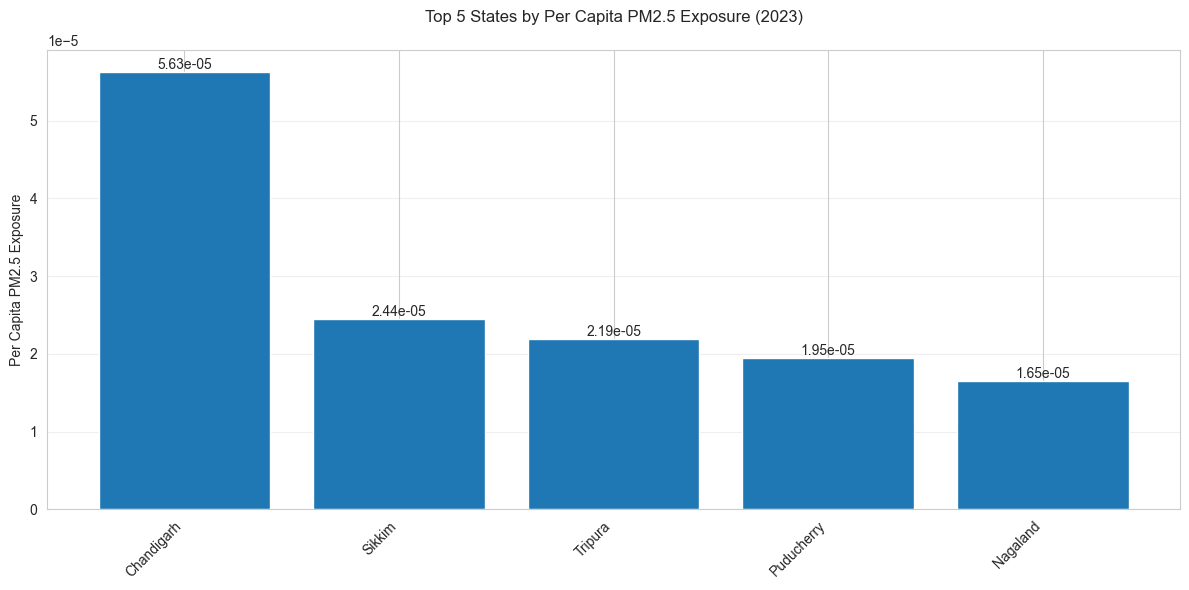


Detailed Statistics for Top 5 States:
--------------------------------------------------

Chandigarh:
Average PM2.5: 59.41 µg/m³
Population: 1,055,450
Per Capita Exposure: 5.63e-05

Sikkim:
Average PM2.5: 14.93 µg/m³
Population: 610,577
Per Capita Exposure: 2.44e-05

Tripura:
Average PM2.5: 80.47 µg/m³
Population: 3,673,917
Per Capita Exposure: 2.19e-05

Puducherry:
Average PM2.5: 24.29 µg/m³
Population: 1,247,953
Per Capita Exposure: 1.95e-05

Nagaland:
Average PM2.5: 32.72 µg/m³
Population: 1,978,502
Per Capita Exposure: 1.65e-05


In [ ]:
df['date'] = pd.to_datetime(df['Timestamp'])
df_2023 = df[df['date'].dt.year == 2023].copy()

# Calculate average PM2.5 for each state in 2023
state_pm25 = df_2023.groupby('state')['PM2.5'].mean()

# Create DataFrame with state populations
pollution_df = pd.DataFrame({
    'PM2.5': state_pm25,
    'population': statedata.set_index('State')['Population']
})

# Calculate per capita PM2.5 exposure
pollution_df['per_capita_exposure'] = pollution_df['PM2.5'] / pollution_df['population']

# Sort and get top 5 states
top_5_states = pollution_df['per_capita_exposure'].sort_values(ascending=False).head(5)

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top_5_states)), top_5_states.values)
plt.xticks(range(len(top_5_states)), top_5_states.index, rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2e}',
             ha='center', va='bottom')

plt.title('Top 5 States by Per Capita PM2.5 Exposure (2023)', pad=20)
plt.ylabel('Per Capita PM2.5 Exposure')
plt.grid(axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print detailed statistics
print("\nDetailed Statistics for Top 5 States:")
print("-" * 50)
for state in top_5_states.index:
    print(f"\n{state}:")
    print(f"Average PM2.5: {pollution_df.loc[state, 'PM2.5']:.2f} µg/m³")
    print(f"Population: {pollution_df.loc[state, 'population']:,.0f}")
    print(f"Per Capita Exposure: {pollution_df.loc[state, 'per_capita_exposure']:.2e}")

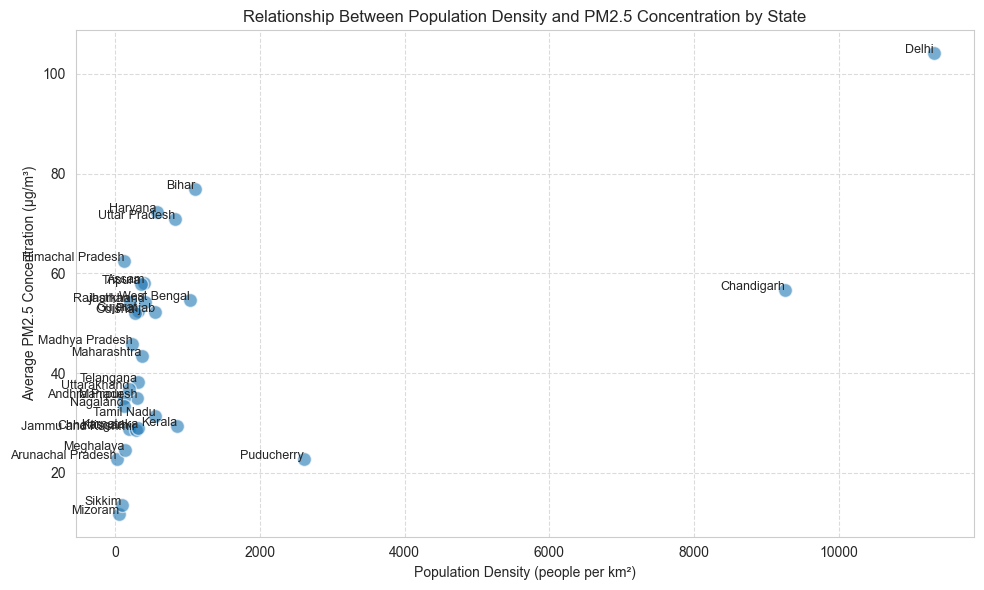

In [ ]:
statedata['Population Density'] = statedata['Population'] / statedata['Area (km2)']
state_pm25 = df.groupby('state')['PM2.5'].mean().reset_index()
merged_data = pd.merge(state_pm25, statedata, left_on='state', right_on='State', how='inner')
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Population Density'], merged_data['PM2.5'], alpha=0.6, edgecolors='w', s=100)
plt.xlabel('Population Density (people per km²)')
plt.ylabel('Average PM2.5 Concentration (µg/m³)')
plt.title('Relationship Between Population Density and PM2.5 Concentration by State')
for i, row in merged_data.iterrows():
    plt.text(row['Population Density'], row['PM2.5'], row['state'], fontsize=9, ha='right')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Area based

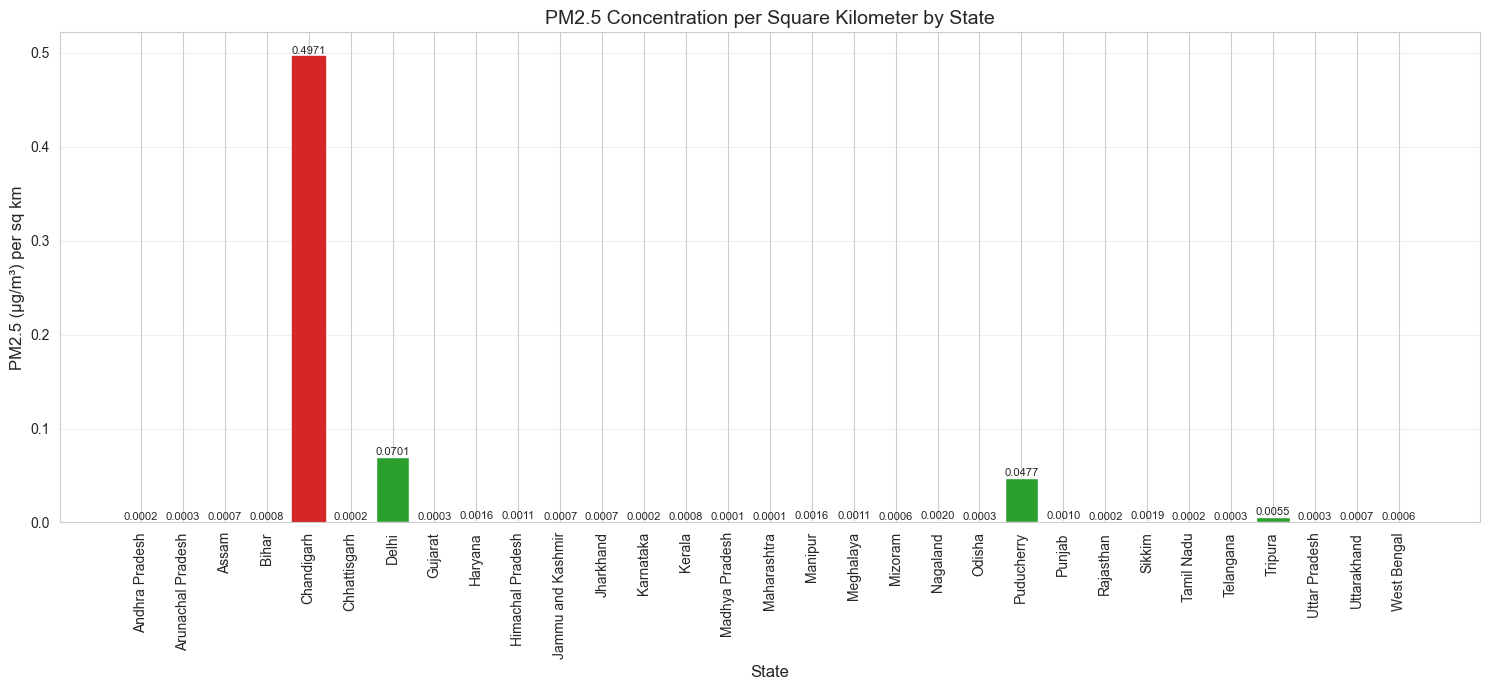

State with highest PM2.5/sq km: Chandigarh (0.50 µg/m³ per km²)


In [ ]:
df_cleaned = df.dropna(subset=['PM2.5', 'state'])
merged = pd.merge(
    df_cleaned.groupby('state')['PM2.5'].mean().reset_index(),
    statedata[['State', 'Area (km2)']].rename(columns={'State': 'state', 'Area (km2)': 'area_sq_km'}),
    on='state',
    how='left'
)
merged['PM2.5_per_sq_km'] = merged['PM2.5'] / merged['area_sq_km']
merged = merged.dropna(subset=['area_sq_km'])
highest_state = merged.loc[merged['PM2.5_per_sq_km'].idxmax()]
plt.figure(figsize=(15, 7))
bars = plt.bar(merged['state'], merged['PM2.5_per_sq_km'], color='#2ca02c')
bars[merged['state'].tolist().index(highest_state['state'])].set_color('#d62728')
plt.title('PM2.5 Concentration per Square Kilometer by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('PM2.5 (µg/m³) per sq km', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=0, fontsize=8)
plt.show()
print(f"State with highest PM2.5/sq km: {highest_state['state']} ({highest_state['PM2.5_per_sq_km']:.2f} µg/m³ per km²)")

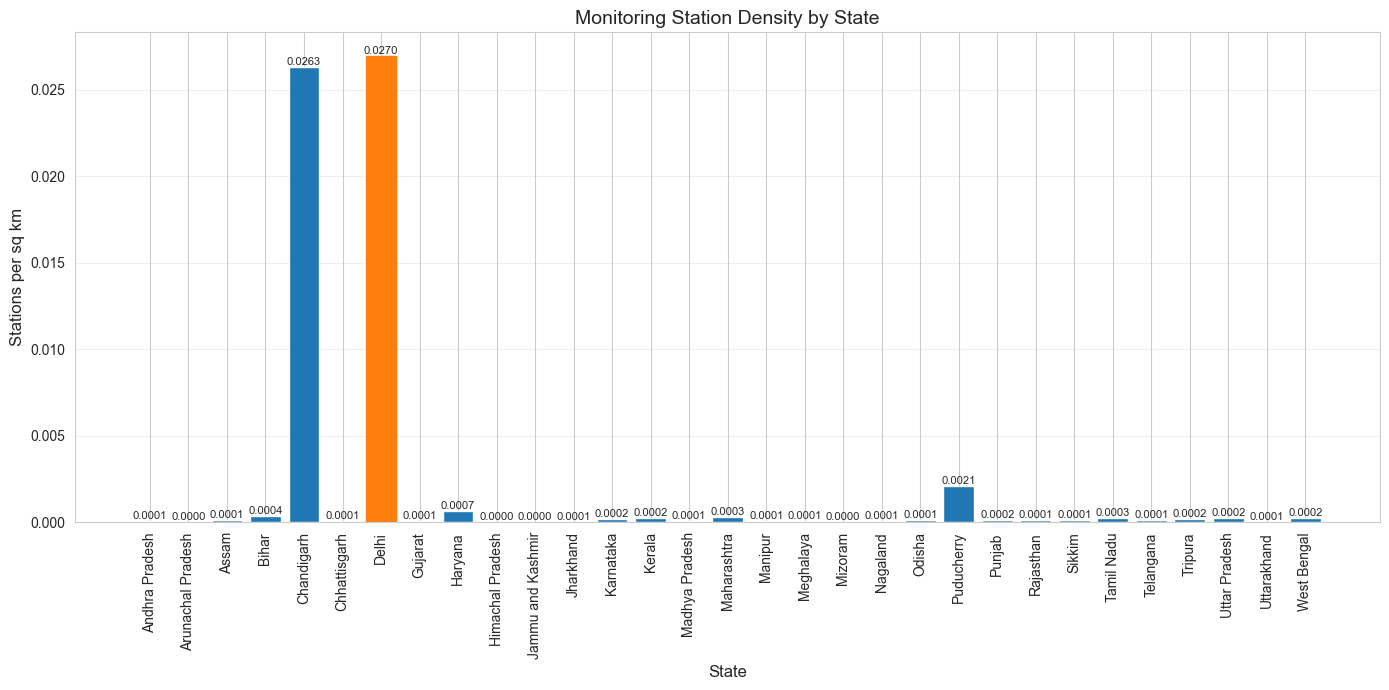

State with highest monitoring station density: Delhi (0.0270 stations/km²)


In [ ]:
stations_per_state = df.groupby('state')['station'].nunique().reset_index()
stations_per_state.columns = ['state', 'num_stations']
merged = pd.merge(stations_per_state,
                 statedata[['State', 'Area (km2)']].rename(columns={'State': 'state', 'Area (km2)': 'area_sq_km'}),
                 on='state',
                 how='left')
merged['stations_per_sq_km'] = merged['num_stations'] / merged['area_sq_km']
merged = merged.dropna(subset=['area_sq_km'])
highest_density = merged.loc[merged['stations_per_sq_km'].idxmax()]
plt.figure(figsize=(14, 7))
bars = plt.bar(merged['state'], merged['stations_per_sq_km'], color='#1f77b4')
bars[merged['state'].tolist().index(highest_density['state'])].set_color('#ff7f0e')
plt.title('Monitoring Station Density by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Stations per sq km', fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
print(f"State with highest monitoring station density: {highest_density['state']} ({highest_density['stations_per_sq_km']:.4f} stations/km²)")

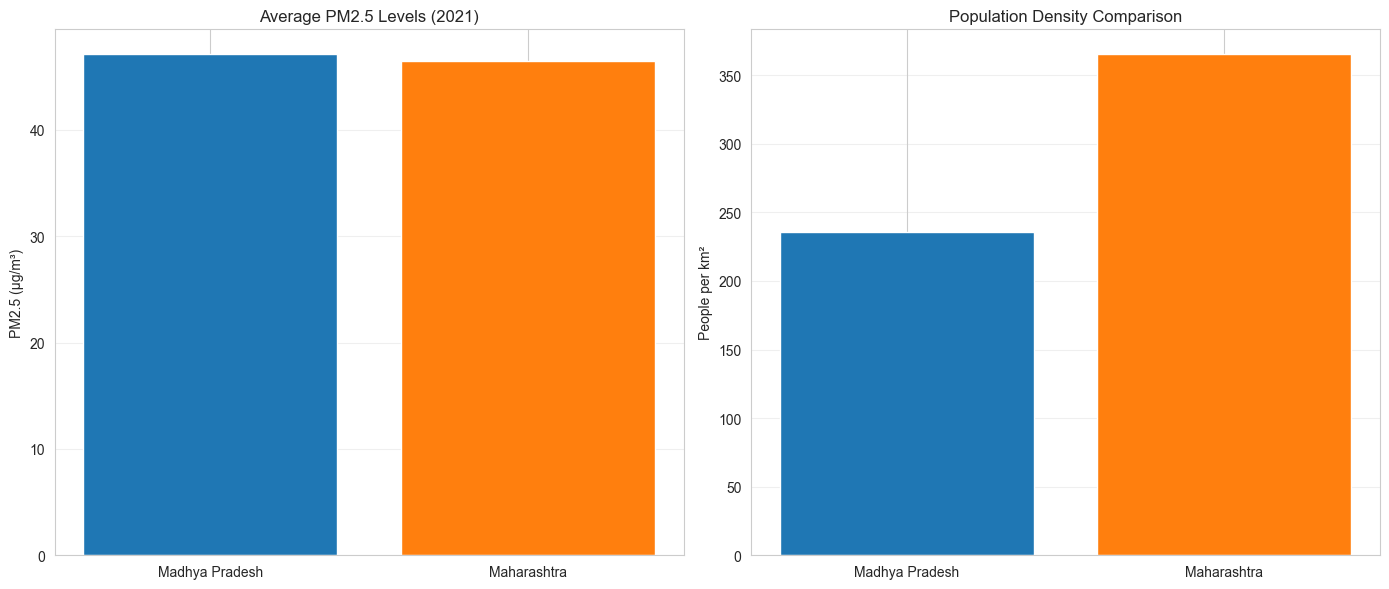

Comparative Analysis:
1. Maharashtra PM2.5: 47.10 µg/m³
   Population Density: 235.61 people/km²
2. Madhya Pradesh PM2.5: 46.44 µg/m³
   Population Density: 365.19 people/km²
Density Ratio (MH/MP): 0.65x
PM2.5 Ratio (MH/MP): 1.01x


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
mask = (df['year'] == 2021) & (df['state'].isin(['Maharashtra', 'Madhya Pradesh']))
filtered = df[mask].dropna(subset=['PM2.5'])
pm25_avg = filtered.groupby('state')['PM2.5'].mean().reset_index()
pop_density = statedata[statedata['State'].isin(['Maharashtra', 'Madhya Pradesh'])].copy()
pop_density['density'] = pop_density['Population'] / pop_density['Area (km2)']
pop_density = pop_density[['State', 'density']].rename(columns={'State': 'state'})
analysis_df = pd.merge(pm25_avg, pop_density, on='state')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.bar(analysis_df['state'], analysis_df['PM2.5'], color=['#1f77b4', '#ff7f0e'])
ax1.set_title('Average PM2.5 Levels (2021)')
ax1.set_ylabel('PM2.5 (µg/m³)')
ax1.grid(axis='y', alpha=0.3)
ax2.bar(analysis_df['state'], analysis_df['density'], color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Population Density Comparison')
ax2.set_ylabel('People per km²')
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("Comparative Analysis:")
print(f"1. Maharashtra PM2.5: {analysis_df.loc[0, 'PM2.5']:.2f} µg/m³")
print(f"   Population Density: {analysis_df.loc[0, 'density']:.2f} people/km²")
print(f"2. Madhya Pradesh PM2.5: {analysis_df.loc[1, 'PM2.5']:.2f} µg/m³")
print(f"   Population Density: {analysis_df.loc[1, 'density']:.2f} people/km²")

density_ratio = analysis_df.loc[0, 'density']/analysis_df.loc[1, 'density']
pm25_ratio = analysis_df.loc[0, 'PM2.5']/analysis_df.loc[1, 'PM2.5']
print(f"Density Ratio (MH/MP): {density_ratio:.2f}x")
print(f"PM2.5 Ratio (MH/MP): {pm25_ratio:.2f}x")

### Funding based

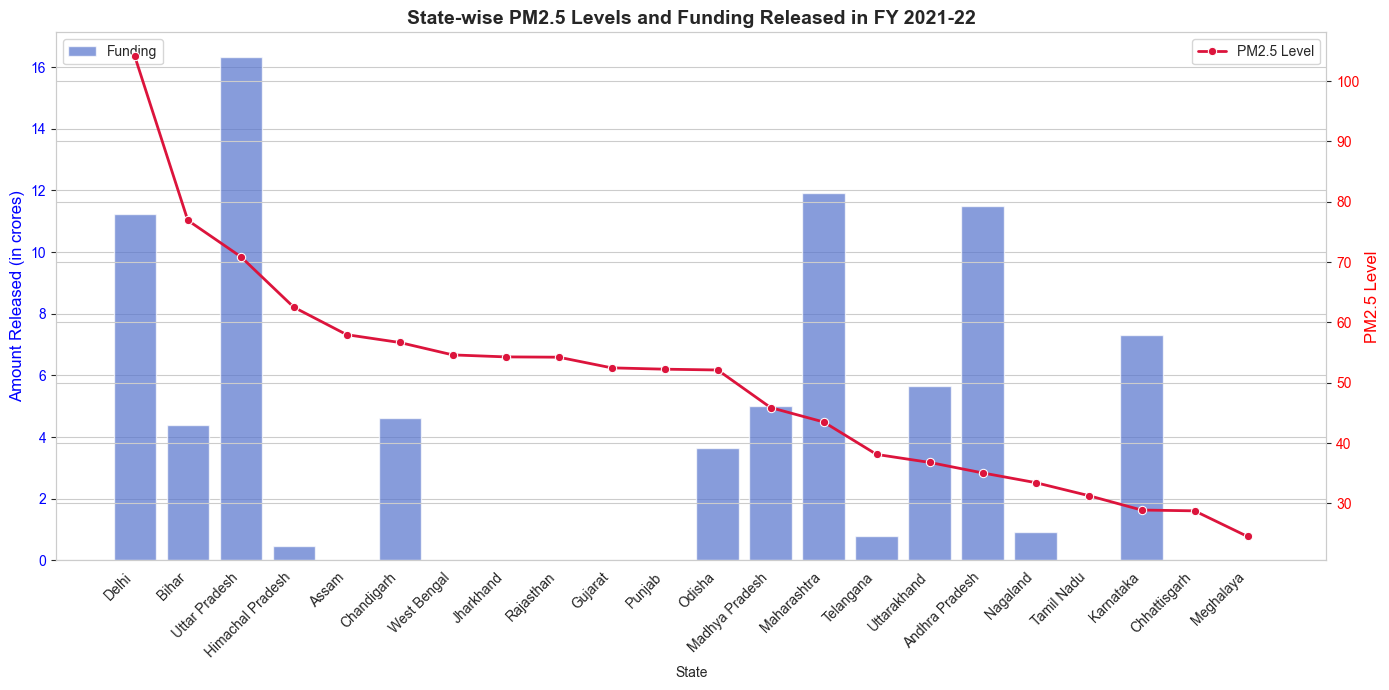

In [ ]:
invalid_values = ['', None, np.nan, 'NA', 'N/A', 'n/a', 'na', 'NaN', 'nan', '-', not int]
funding.replace(invalid_values, np.nan, inplace=True)
funding.fillna(0, inplace=True)
df.rename(columns={'state' : 'State', 'city' : 'City'}, inplace=True)
combined = pd.merge(df, funding, on='City')
combined.drop('State_y', axis=1, inplace=True)
combined.rename(columns={'State_x': 'State'}, inplace=True)
funding['Amount released during FY 2021-22'] = pd.to_numeric(funding['Amount released during FY 2021-22'], errors='coerce')
statefundingdata21 = funding.groupby('State')['Amount released during FY 2021-22'].sum().reset_index()
statepm25data21 = df.groupby('State')['PM2.5'].mean().reset_index()
combined_data = pd.merge(statefundingdata21, statepm25data21, on='State')
combined_data = combined_data.sort_values(by='PM2.5', ascending=False)
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()
sns.barplot(x='State', y='Amount released during FY 2021-22', data=combined_data, ax=ax1, color='royalblue', alpha=0.7, label='Funding')
ax1.set_ylabel('Amount Released (in crores)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
sns.lineplot(x='State', y='PM2.5', data=combined_data, ax=ax2, color='crimson', marker='o', linewidth=2, label='PM2.5 Level')
ax2.set_ylabel('PM2.5 Level', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('State-wise PM2.5 Levels and Funding Released in FY 2021-22', fontsize=14, fontweight='bold')
ax1.set_xticklabels(combined_data['State'], rotation=45, ha='right', fontsize=10)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

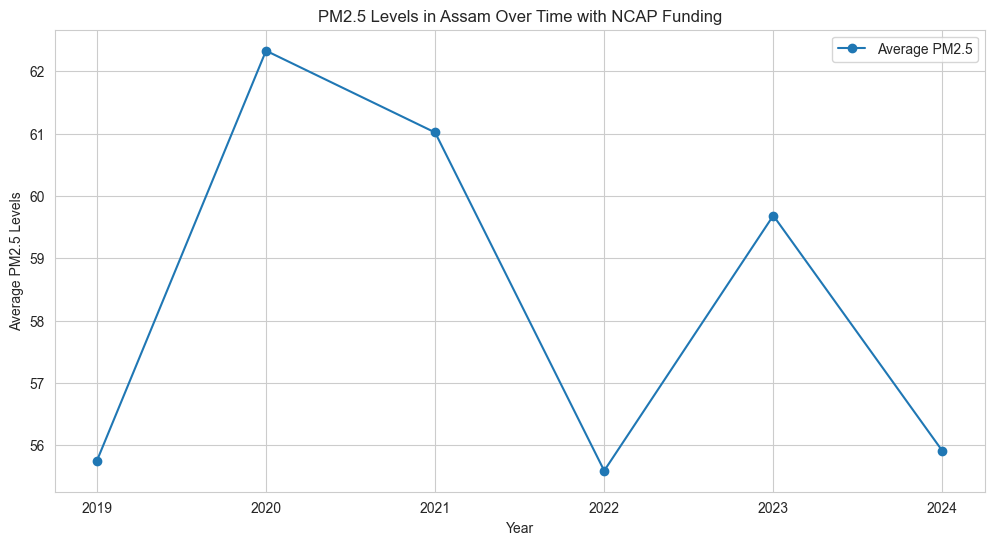


NCAP funding has not led to noticeable improvements in air quality in Assam.


In [ ]:
assam_data = df[df['State'] == 'Assam']
assam_avg_pm25 = assam_data.groupby(assam_data['Timestamp'].dt.year)['PM2.5'].mean().reset_index()
assam_avg_pm25.rename(columns={'Timestamp': 'year'}, inplace=True)

# Merge
assam_funding = funding[funding['State'] == 'Assam']
assam_avg_pm25 = pd.merge(assam_avg_pm25, assam_funding, left_on='year', right_on='Total fund released', how='left')

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(assam_avg_pm25['year'], assam_avg_pm25['PM2.5'], label='Average PM2.5', marker='o')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 Levels')
plt.title('PM2.5 Levels in Assam Over Time with NCAP Funding')
plt.legend()
plt.grid(True)

for i, row in assam_avg_pm25.iterrows():
    if row['Total fund released'] > 0:
        plt.scatter(row['year'], row['PM2.5'], color='red', zorder=5)

plt.show()

# Analyze the impact of funding
if assam_avg_pm25['PM2.5'].iloc[-1] < assam_avg_pm25['PM2.5'].iloc[0]:
    print("\nNCAP funding has led to noticeable improvements in air quality in Assam.")
else:
    print("\nNCAP funding has not led to noticeable improvements in air quality in Assam.")

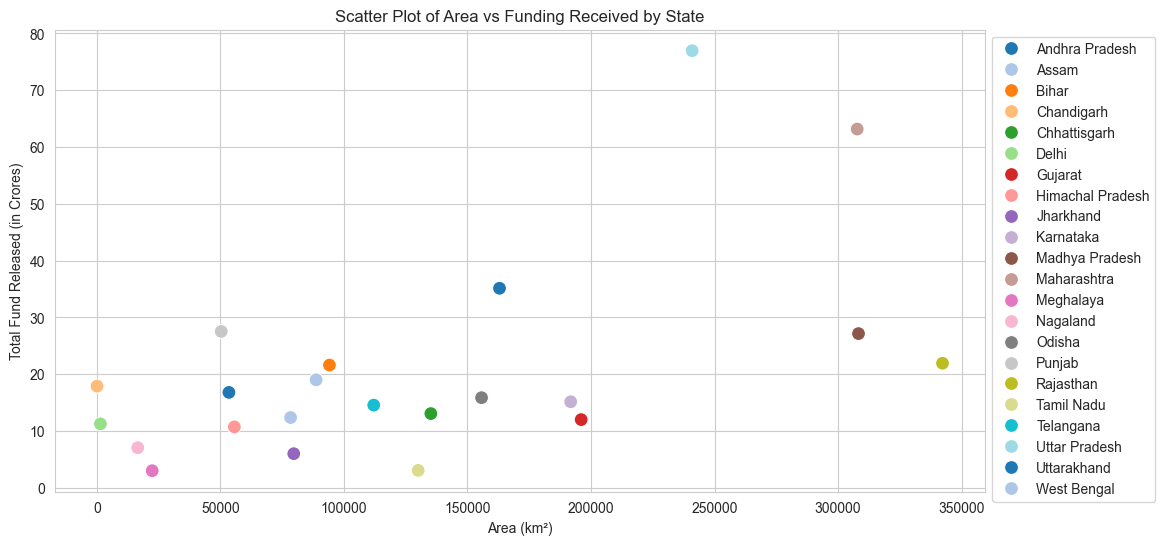

In [ ]:
statefundingdata = funding.groupby('State')['Total fund released'].sum().reset_index()
combined = pd.merge(statefundingdata, statedata, left_on='State', right_on='State')
combined = combined.drop(columns=['Population'])
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined, x="Area (km2)", y="Total fund released", hue="State", palette="tab20", s=100)
plt.xlabel("Area (km²)")
plt.ylabel("Total Fund Released (in Crores)")
plt.title("Scatter Plot of Area vs Funding Received by State")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


### Miscellaneous Questions

In [ ]:
city_avg_2023 = df[df['year'] == 2023].groupby('City')['PM2.5'].mean()
most_polluted_city = city_avg_2023.idxmax()
highest_avg = city_avg_2023.max()
city_data = df[(df['year'] == 2023) & (df['City'] == most_polluted_city)]
total_days = len(city_data)
hazardous_days = len(city_data[city_data['PM2.5'] > 300])
hazardous_percentage = (hazardous_days / total_days) * 100

print(f"Most polluted city in 2023: {most_polluted_city}")
print(f"Average PM2.5 level: {highest_avg:.2f} µg/m³")
print(f"Percentage of days with hazardous levels: {hazardous_percentage:.2f}%")
print(f"({hazardous_days} out of {total_days} days)")

Most polluted city in 2023: Darbhanga
Average PM2.5 level: 242.92 µg/m³
Percentage of days with hazardous levels: 21.43%
(3 out of 14 days)



Festival Period Analysis (±7 days around festival):
--------------------------------------------------

Diwali 2018:
Maximum PM2.5: 349.2 µg/m³
Average PM2.5: 89.6 µg/m³
Days above hazardous level: 2

New Year 2019:
Maximum PM2.5: 561.4 µg/m³
Average PM2.5: 276.9 µg/m³
Days above hazardous level: 206

Diwali 2019:
Maximum PM2.5: 712.1 µg/m³
Average PM2.5: 233.4 µg/m³
Days above hazardous level: 157

New Year 2020:
Maximum PM2.5: 502.4 µg/m³
Average PM2.5: 241.8 µg/m³
Days above hazardous level: 131

Diwali 2020:
Maximum PM2.5: 699.0 µg/m³
Average PM2.5: 235.2 µg/m³
Days above hazardous level: 166

New Year 2021:
Maximum PM2.5: 414.5 µg/m³
Average PM2.5: 194.4 µg/m³
Days above hazardous level: 31


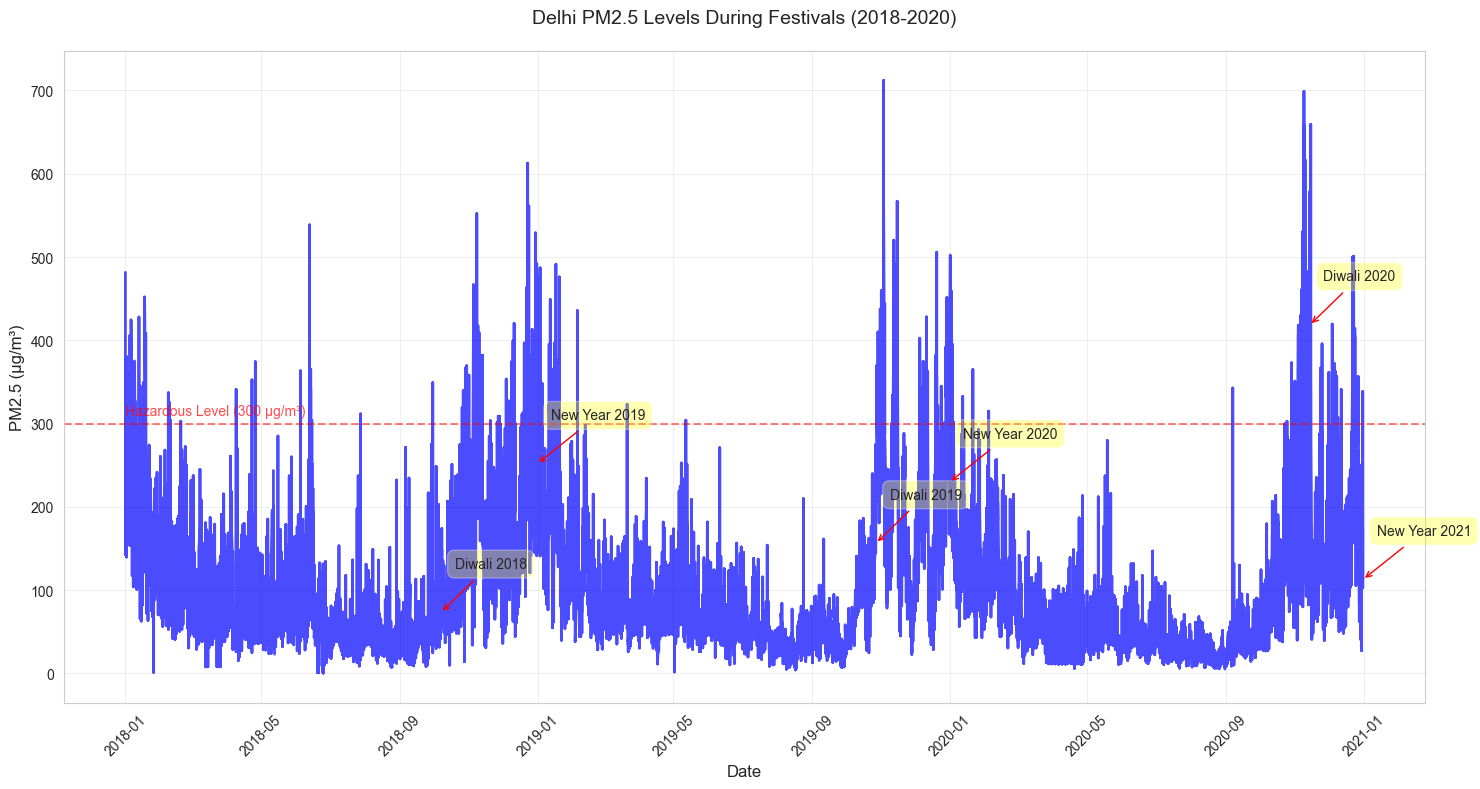

In [ ]:
# Create figure and axis with larger size
fig, ax = plt.subplots(figsize=(15, 8))

# Filter data for Delhi 2018-2020
delhi_data = df[
    (df['City'] == 'Delhi') &
    (df['year'].between(2018, 2020))
].copy()

# Convert to datetime for better plotting
delhi_data['date'] = pd.to_datetime(delhi_data['Timestamp'])

# Sort by date
delhi_data = delhi_data.sort_values('date')

# Plot the PM2.5 levels
ax.plot(delhi_data['date'], delhi_data['PM2.5'],
        color='blue', alpha=0.7, linewidth=2)

# Define festival dates
festivals = {
    '2018-10-07': 'Diwali 2018',
    '2018-12-31': 'New Year 2019',
    '2019-10-27': 'Diwali 2019',
    '2019-12-31': 'New Year 2020',
    '2020-11-14': 'Diwali 2020',
    '2020-12-31': 'New Year 2021'
}

# Add festival markers and annotations
for date, festival in festivals.items():
    date = pd.to_datetime(date)
    # Find the PM2.5 value for this date
    value = delhi_data[delhi_data['date'] == date]['PM2.5'].values
    if len(value) > 0:
        value = value[0]
        # Add arrow and text
        ax.annotate(festival,
                   xy=(date, value),
                   xytext=(10, 30),
                   textcoords='offset points',
                   ha='left',
                   va='bottom',
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                   arrowprops=dict(arrowstyle='->', color='red'))

# Customize the plot
ax.set_title('Delhi PM2.5 Levels During Festivals (2018-2020)', fontsize=14, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('PM2.5 (µg/m³)', fontsize=12)

# Add horizontal line for hazardous level
ax.axhline(y=300, color='red', linestyle='--', alpha=0.5)
ax.text(delhi_data['date'].iloc[0], 310, 'Hazardous Level (300 µg/m³)',color='red', alpha=0.7)
plt.xticks(rotation=45)
ax.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate statistics for festival periods
def get_festival_stats(data, festival_date, window_days=7):
    festival_date = pd.to_datetime(festival_date)
    window_before = festival_date - pd.Timedelta(days=window_days)
    window_after = festival_date + pd.Timedelta(days=window_days)

    festival_period = data[
        (data['date'] >= window_before) &
        (data['date'] <= window_after)
    ]

    return {
        'max_pm25': festival_period['PM2.5'].max(),
        'mean_pm25': festival_period['PM2.5'].mean(),
        'days_above_hazardous': (festival_period['PM2.5'] > 300).sum()
    }

# Print analysis results
print("\nFestival Period Analysis (±7 days around festival):")
print("-" * 50)
for date, name in festivals.items():
    stats = get_festival_stats(delhi_data, date)
    print(f"\n{name}:")
    print(f"Maximum PM2.5: {stats['max_pm25']:.1f} µg/m³")
    print(f"Average PM2.5: {stats['mean_pm25']:.1f} µg/m³")
    print(f"Days above hazardous level: {stats['days_above_hazardous']}")

# Show plot
plt.show()

State with highest NCAP funding in 2020-21: Andhra Pradesh
Total funding received: ₹17.28 crores


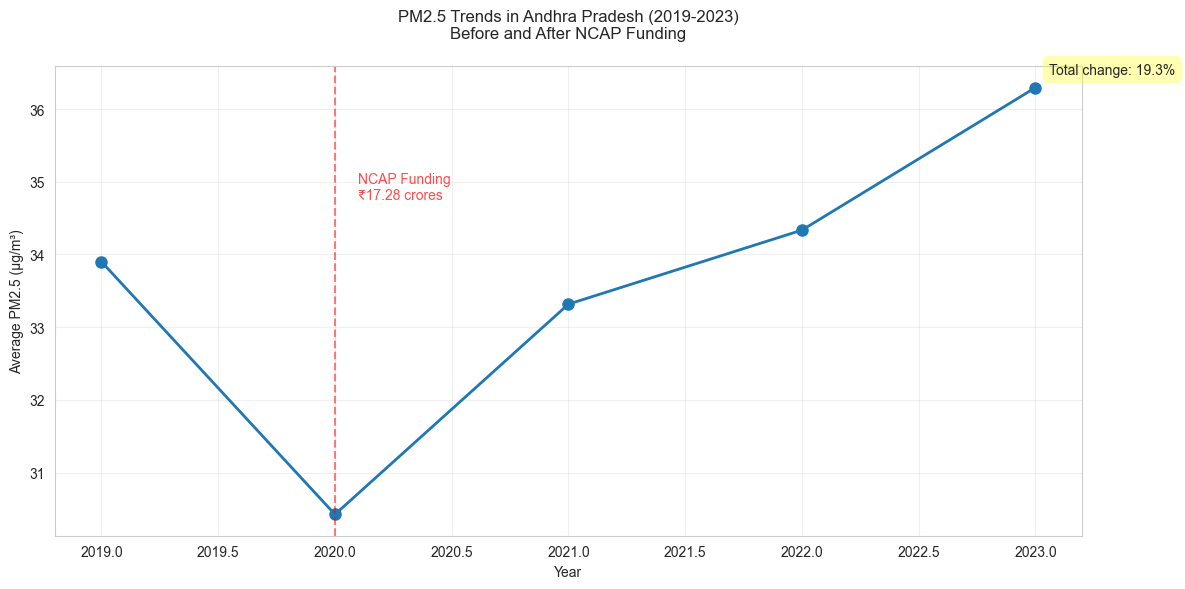


Yearly PM2.5 Averages:
2019: 33.90 µg/m³
2020: 30.43 µg/m³
2021: 33.32 µg/m³
2022: 34.33 µg/m³
2023: 36.29 µg/m³

Overall change in PM2.5 from 2020 to 2023: 19.3%


In [ ]:
funding['Amount released during FY 2020-21'] = pd.to_numeric(
    funding['Amount released during FY 2020-21'], errors='coerce'
)
state_funding = funding.groupby('State')['Amount released during FY 2020-21'].sum()
highest_funded_state = state_funding.idxmax()
highest_funding = state_funding.max()

print(f"State with highest NCAP funding in 2020-21: {highest_funded_state}")
print(f"Total funding received: ₹{highest_funding} crores")

# Analyze pollution data for this state
state_data = df[
    (df['State'] == highest_funded_state) &
    (df['year'].between(2019, 2023))
].copy()

# Calculate yearly averages
yearly_avg = state_data.groupby('year')['PM2.5'].mean()

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot the line
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=8)

# Add funding marker
plt.axvline(x=2020, color='r', linestyle='--', alpha=0.5)
plt.text(2020.1, plt.ylim()[1]*0.95, f'NCAP Funding\n₹{highest_funding} crores',
         color='r', alpha=0.7)

# Customize the plot
plt.title(f'PM2.5 Trends in {highest_funded_state} (2019-2023)\nBefore and After NCAP Funding',
          pad=20)
plt.xlabel('Year')
plt.ylabel('Average PM2.5 (µg/m³)')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Calculate and display percentage change
initial_pm25 = yearly_avg[2020]
final_pm25 = yearly_avg[2023]
percent_change = ((final_pm25 - initial_pm25) / initial_pm25) * 100

# Add annotation for percent change
plt.annotate(f'Total change: {percent_change:.1f}%',
             xy=(2023, final_pm25),
             xytext=(10, 10),
             textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nYearly PM2.5 Averages:")
for year, avg in yearly_avg.items():
    print(f"{year}: {avg:.2f} µg/m³")

print(f"\nOverall change in PM2.5 from 2020 to 2023: {percent_change:.1f}%")


Sensor Distribution by State:
Maharashtra: 97 stations
Uttar Pradesh: 57 stations
Rajasthan: 46 stations
Karnataka: 42 stations
Delhi: 40 stations
Bihar: 36 stations
Tamil Nadu: 36 stations
Haryana: 32 stations
Madhya Pradesh: 29 stations
West Bengal: 22 stations
Odisha: 19 stations
Gujarat: 17 stations
Telangana: 14 stations
Chhattisgarh: 14 stations
Andhra Pradesh: 13 stations
Kerala: 9 stations
Assam: 9 stations
Punjab: 8 stations
Jharkhand: 4 stations
Uttarakhand: 3 stations
Chandigarh: 3 stations
Meghalaya: 2 stations
Tripura: 2 stations
Manipur: 2 stations
Nagaland: 1 stations
Puducherry: 1 stations
Jammu and Kashmir: 1 stations
Arunachal Pradesh: 1 stations
Himachal Pradesh: 1 stations
Sikkim: 1 stations
Mizoram: 1 stations


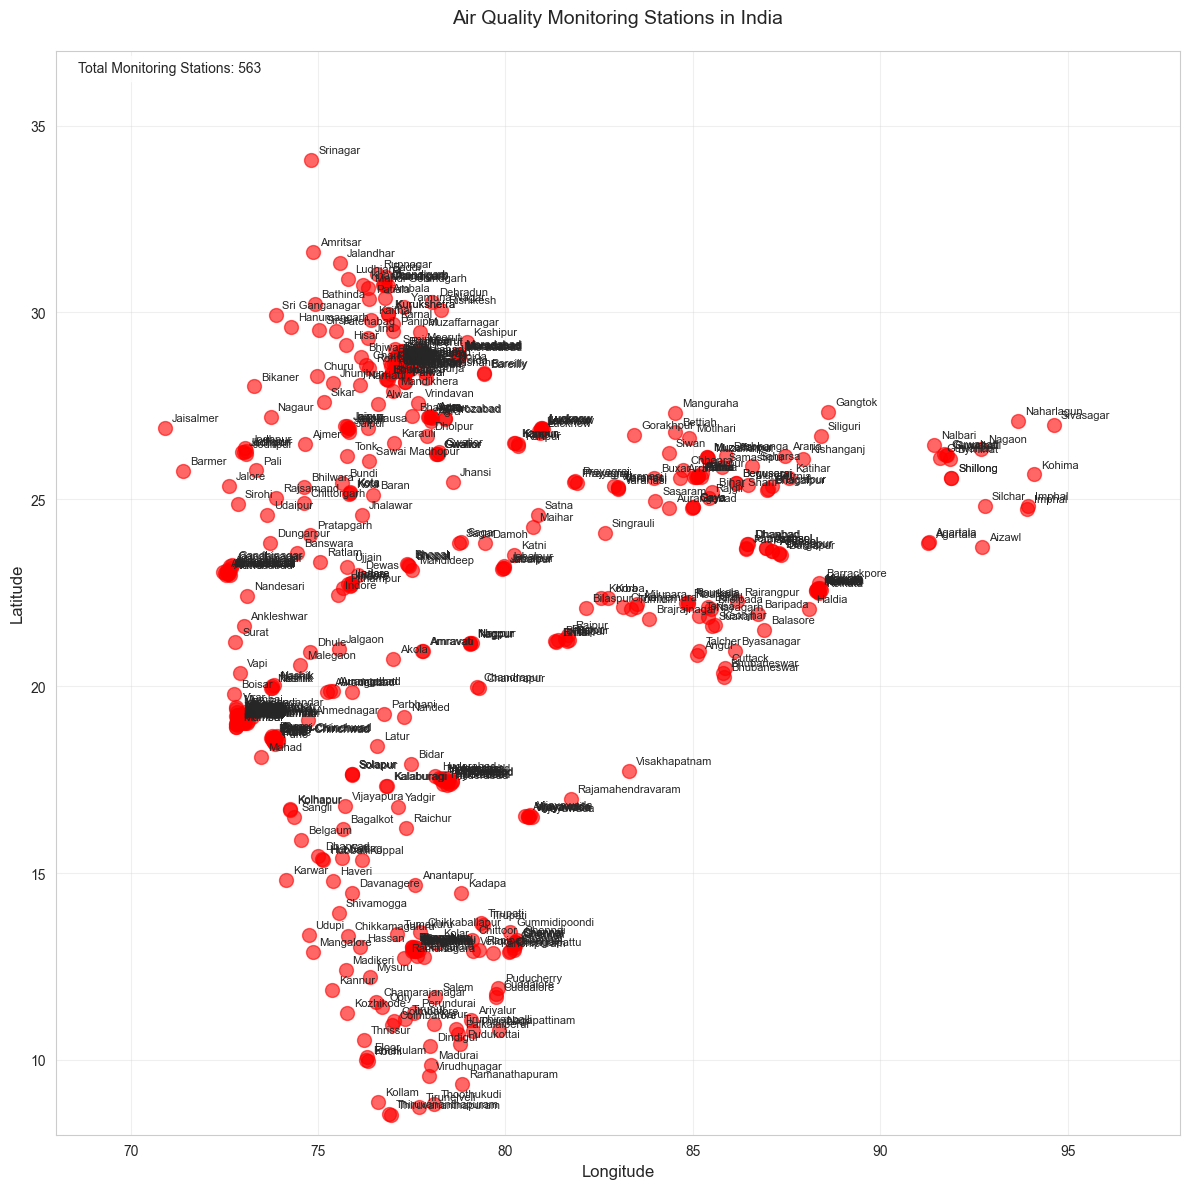

In [ ]:
# Create figure and axis with larger size
plt.figure(figsize=(12, 12))

# Get unique sensor locations to avoid duplicates
unique_locations = df[['latitude', 'longitude', 'City', 'State']].drop_duplicates()

# Create scatter plot
plt.scatter(unique_locations['longitude'],
           unique_locations['latitude'],
           c='red',
           alpha=0.6,
           s=100)

# Add labels for major cities
for idx, row in unique_locations.iterrows():
    plt.annotate(row['City'],
                (row['longitude'], row['latitude']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)

# Customize the plot
plt.title('Air Quality Monitoring Stations in India', pad=20, fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Set map bounds to focus on India
plt.xlim(68, 98)
plt.ylim(8, 37)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add text showing total number of stations
plt.text(0.02, 0.98,
         f'Total Monitoring Stations: {len(unique_locations)}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Print statistics
print("\nSensor Distribution by State:")
state_counts = unique_locations['State'].value_counts()
for state, count in state_counts.items():
    print(f"{state}: {count} stations")

plt.tight_layout()
plt.show()

### Tell us something new

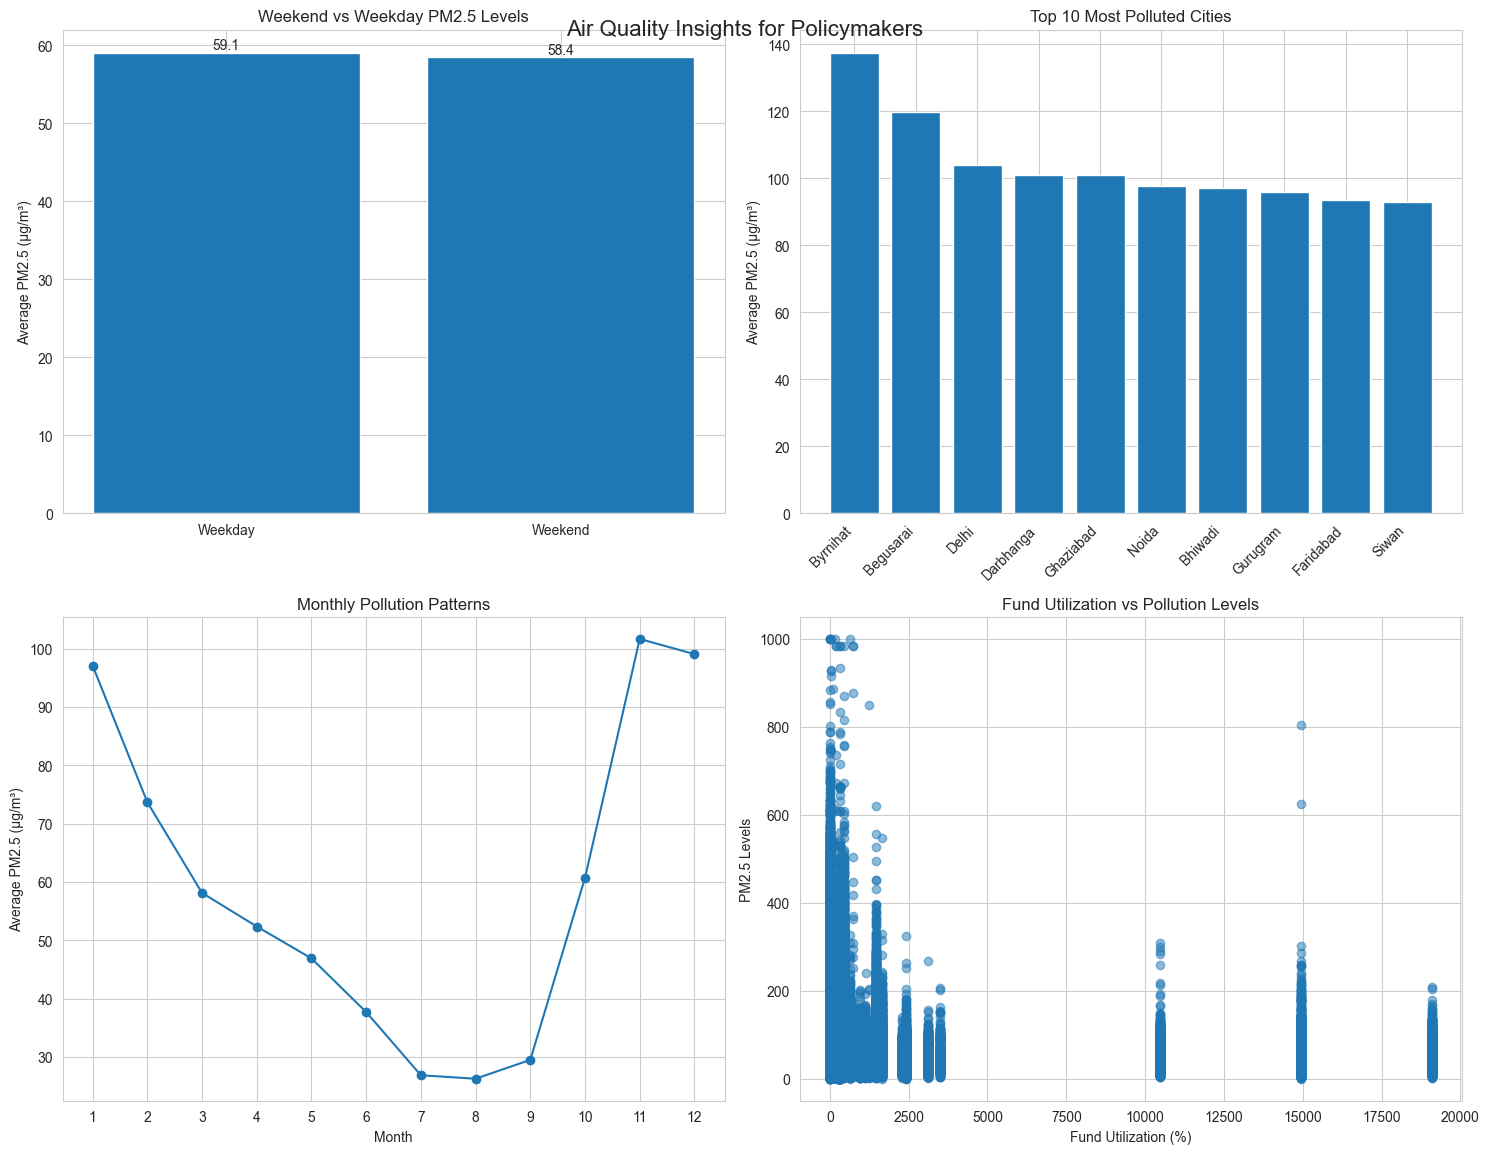


Key Findings for Policymakers:

1. Weekend Effect:
   - Pollution reduces by 1.0% on weekends
   - This suggests traffic and industrial activity significantly impact air quality

2. City Pollution Rankings:
   Top 5 most polluted cities and their average PM2.5 levels:
   - Byrnihat: 137.5 µg/m³
   - Begusarai: 119.8 µg/m³
   - Delhi: 104.1 µg/m³
   - Darbhanga: 101.0 µg/m³
   - Ghaziabad: 100.9 µg/m³

3. Seasonal Patterns:
   - Worst air quality in month 11 (avg PM2.5: 101.6)
   - Best air quality in month 8 (avg PM2.5: 26.3)

4. NCAP Fund Utilization:
   - Average fund utilization: 828.9%
   - Cities with highest fund utilization:
   - Visakhapatnam: 19091.7%
   - Aurangabad: 14960.0%
   - Nashik: 14960.0%
   - Indore: 10480.0%
   - Jalgaon: 3479.1%


In [ ]:
from datetime import datetime

# 1. Analysis of Weekend vs Weekday Pollution
df['date'] = pd.to_datetime(df['Timestamp'])
df['is_weekend'] = df['date'].dt.weekday >= 5

# Create figure with multiple subplots
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Air Quality Insights for Policymakers', fontsize=16, y=0.95)

# 1. Weekend vs Weekday Analysis
ax1 = plt.subplot(2, 2, 1)
weekday_avg = df[~df['is_weekend']]['PM2.5'].mean()
weekend_avg = df[df['is_weekend']]['PM2.5'].mean()

bars = ax1.bar(['Weekday', 'Weekend'], [weekday_avg, weekend_avg])
ax1.set_title('Weekend vs Weekday PM2.5 Levels')
ax1.set_ylabel('Average PM2.5 (µg/m³)')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# 2. Correlation between City Population and Pollution
ax2 = plt.subplot(2, 2, 2)
city_avg_pollution = df.groupby('City')['PM2.5'].mean().sort_values(ascending=False)
top_10_polluted = city_avg_pollution.head(10)
ax2.bar(range(len(top_10_polluted)), top_10_polluted)
ax2.set_xticks(range(len(top_10_polluted)))
ax2.set_xticklabels(top_10_polluted.index, rotation=45, ha='right')
ax2.set_title('Top 10 Most Polluted Cities')
ax2.set_ylabel('Average PM2.5 (µg/m³)')

# 3. Seasonal Patterns
df['month'] = df['date'].dt.month
monthly_avg = df.groupby('month')['PM2.5'].mean()
ax3 = plt.subplot(2, 2, 3)
ax3.plot(monthly_avg.index, monthly_avg.values, marker='o')
ax3.set_xticks(range(1, 13))
ax3.set_xlabel('Month')
ax3.set_ylabel('Average PM2.5 (µg/m³)')
ax3.set_title('Monthly Pollution Patterns')

# 4. NCAP Fund Utilization vs Pollution Reduction
# Merge pollution data with funding data
funded_cities = pd.merge(df, funding,
                        left_on=['City'],
                        right_on=['City'],
                        how='inner')

funded_cities['Utilisation as on June 2022'] = pd.to_numeric(funded_cities['Utilisation as on June 2022'], errors='coerce')
funded_cities['Total fund released'] = pd.to_numeric(funded_cities['Total fund released'], errors='coerce')
# Calculate fund utilization percentage
funded_cities['utilization_percent'] = ((funded_cities['Utilisation as on June 2022'] /
                                      funded_cities['Total fund released']) * 100)

ax4 = plt.subplot(2, 2, 4)
ax4.scatter(funded_cities['utilization_percent'],
           funded_cities['PM2.5'],
           alpha=0.5)
ax4.set_xlabel('Fund Utilization (%)')
ax4.set_ylabel('PM2.5 Levels')
ax4.set_title('Fund Utilization vs Pollution Levels')

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings for Policymakers:")

# 1. Weekend Effect
weekend_reduction = ((weekday_avg - weekend_avg) / weekday_avg) * 100
print(f"\n1. Weekend Effect:")
print(f"   - Pollution reduces by {weekend_reduction:.1f}% on weekends")
print(f"   - This suggests traffic and industrial activity significantly impact air quality")

# 2. City Rankings
print("\n2. City Pollution Rankings:")
print("   Top 5 most polluted cities and their average PM2.5 levels:")
for city, level in city_avg_pollution.head().items():
    print(f"   - {city}: {level:.1f} µg/m³")

# 3. Seasonal Patterns
worst_month = monthly_avg.idxmax()
best_month = monthly_avg.idxmin()
print(f"\n3. Seasonal Patterns:")
print(f"   - Worst air quality in month {worst_month} (avg PM2.5: {monthly_avg[worst_month]:.1f})")
print(f"   - Best air quality in month {best_month} (avg PM2.5: {monthly_avg[best_month]:.1f})")

# 4. Fund Utilization
avg_utilization = funded_cities['utilization_percent'].mean()
print(f"\n4. NCAP Fund Utilization:")
print(f"   - Average fund utilization: {avg_utilization:.1f}%")
print(f"   - Cities with highest fund utilization:")
top_utilized = funded_cities.groupby('City')['utilization_percent'].mean().sort_values(ascending=False).head()
for city, util in top_utilized.items():
    print(f"   - {city}: {util:.1f}%")